In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

%matplotlib inline

In [2]:
def plot_series(time, series, format='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)

In [3]:
def trend(time, slope=0.):
    return slope * time

In [4]:
def seasonal_pattern(season_time):
    '''Any arbitrary pattern will do'''
    return np.where(season_time < 0.4, 
                    np.cos(2*np.pi*season_time), 
                    1 / np.exp(3*season_time))

In [5]:
def seasonality(time, period, amplitude=1, phase=0):
    '''Repeats pattern each period'''
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

In [6]:
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [7]:
time = np.arange(4 * 365 + 1, dtype='float32')
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

In [8]:
series = (baseline 
          + trend(time, slope) 
          + seasonality(time, period=365, amplitude=amplitude)
          + noise(time, noise_level))

In [9]:
split_time = 1000
time_train = time[:split_time]
time_valid = time[split_time:]
x_train = series[:split_time]
x_valid = series[split_time:]

In [10]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [11]:
def windowed_data_set(
        series, window_size, batch_size, shuffle_buffer_size):
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window_size + 1, shift=1, drop_remainder=True)
    data = data.flat_map(lambda window: window.batch(window_size + 1))
    data = data.shuffle(shuffle_buffer_size)\
        .map(lambda window: (window[:-1], window[-1]))
    data = data.batch(batch_size).prefetch(1)
    return data

In [12]:
data = windowed_data_set(
    x_train, window_size, batch_size, shuffle_buffer_size)
print(data)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>


In [14]:
layer0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.Sequential([layer0])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss='mse', 
              optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(data, epochs=100, verbose=0)

In [16]:
print(f'Layer weights {layer0.get_weights()}')

Layer weights [array([[-0.05941765],
       [ 0.06567985],
       [-0.04408163],
       [ 0.07169289],
       [-0.04931704],
       [-0.01727135],
       [-0.00725076],
       [-0.03164464],
       [ 0.06763906],
       [ 0.0766921 ],
       [-0.03919793],
       [ 0.03606515],
       [-0.04769331],
       [-0.02378233],
       [-0.02192771],
       [ 0.07831652],
       [ 0.09425683],
       [ 0.2381113 ],
       [ 0.20286083],
       [ 0.41067132]], dtype=float32), array([0.01932777], dtype=float32)]


In [18]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(
        model.predict(series[time:time + window_size][np.newaxis]))
forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

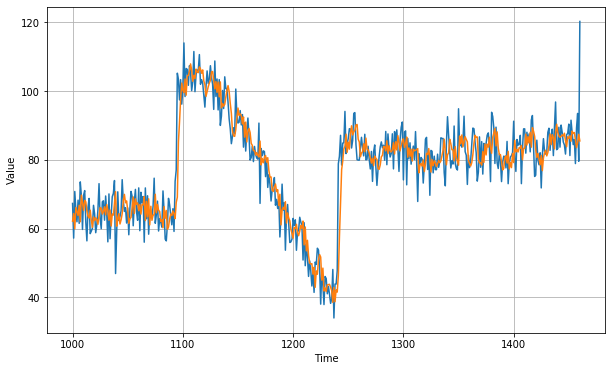

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [20]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.9030843